In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# --------------------------------------------------
# config
# --------------------------------------------------

PREDICT_BATCH_SIZE = 100
TEST_TXT= '/mogu/lingfei/project/cate4/val_data/test_cate4_look_fromsimu.txt'
NUM_CLASSES =24
INPUT_HEIGHT,INPUT_WIDTH =224, 224
MODEL_FILE = '/mogu/lingfei/project/cate4/resnet50/model_file/resnet50.json'
BEST_WEIGHTS_FILE = '/mogu/lingfei/project/cate4/resnet50/model_file/weight-0.8552791150571896.hdf5'
RESULT_DIR = '/mogu/lingfei/project/cate4/resnet50/result_file/'
output_dir = '/mogu/lingfei/project/cate4/resnet50/badcase'

# --------------------------------------------------
# prepare data and load modle
# --------------------------------------------------

import cv2
import numpy as np
import os
from PIL import Image
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import random
import datetime
import time
from keras import models



def load_img_array(image_name, grayscale=False, target_size=(INPUT_HEIGHT, INPUT_WIDTH)):
    img = image.load_img(image_name, grayscale)
    resize_img = img.resize(target_size)
    img_array = image.img_to_array(resize_img)/ 255.0
    return img_array

def test_data_generator(images, batch_size):
    for base in range(0, len(images), batch_size):
        image_batch = []
        for offset in range(batch_size):
            idx = base + offset
            if idx >= len(images):
                break
            image_name = images[idx].split(' ')[0]
            image_array = load_img_array(image_name, grayscale=False)
            image_batch.append(image_array)
        image_batch = np.array(image_batch, np.float32)
        yield image_batch


def load_model(model_file, weights_file):
    model_json_string = ""
    with open(model_file, 'r') as mf:
        for line in mf:
            model_json_string += line
    model = models.model_from_json(model_json_string)
    model.load_weights(weights_file)
    return model

def get_test_imgs(test_txt):
    all_images = []
    with open(TEST_TXT,'r') as f:
        for line in f:
            all_images.append(line.strip('\n'))
    f.close()
    random.shuffle(all_images)
    return all_images[:1000]

# --------------------------------------------------
# predict the category
# --------------------------------------------------
from __future__ import print_function
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#import ImageDraw
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


def find_badcase(image_path, true, pred, output_dir):
    num_to_names={'0':'棒球外套','1':'衬衫','2':'短裤','3':'运动裤','4':'马甲',
                  '5':'连衣裙','6':'棉裤','7':'皮衣','8':'卫衣','9':'毛衣','10':'背心',
                  '11':'雪纺','12':'西装裤','13':'棉衣','14':'大衣','15':'打底裤',
                  '16':'牛仔外套','17':'西装','18':'休闲裤','19':'风衣','20':'半裙',
                  '21':'T恤','22':'牛仔裤','23':'皮草'}
    if int(true) != int(pred):
        img = Image.open(image_path)
        img.save(output_dir + '/' + num_to_names[str(true)] + '_' + num_to_names[str(pred)] 
                 + '-' + image_path.split('/')[-1])        

def predict():
    start_time = datetime.datetime.now()
    model = load_model(MODEL_FILE, BEST_WEIGHTS_FILE)
    all_test_images = get_test_imgs(TEST_TXT)
    test_gen = test_data_generator(all_test_images, PREDICT_BATCH_SIZE)
    y_pr = []
    y_re = []
    i = 0
    for batch in test_gen:
        res_array = model.predict_on_batch(batch)
        for k in range(len(res_array)):
            idx = i + k
            if max(res_array[k]) >= 0.95:
                re_cag = all_test_images[idx].split(' ')[-1] #真实类别
                y_re.append(int(re_cag))
                print(int(re_cag))
                pr_cag = np.argmax(res_array[k],axis = 0) #模型预测类别
                y_pr.append(int(pr_cag))    
                print(int(pr_cag))
                #------------------find badcase
                image_path = all_test_images[idx].split(' ')[0]
                find_badcase(image_path, re_cag, pr_cag, output_dir)
                #-------------------
            if idx % 10000 == 0:
                print ("processed %d images" % idx)
        i += PREDICT_BATCH_SIZE
    end_time = datetime.datetime.now()
    cost_time = end_time - start_time
    print ("predict cost time:", cost_time)
    return y_re, y_pr


def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary): 
        plt.imshow(cm, interpolation='nearest', cmap=cmap) 
        plt.title(title) 
        plt.colorbar() 
        xlocations = np.array(range(len(labels2))) 
        plt.xticks(xlocations, labels2, rotation=0) 
        plt.yticks(xlocations, labels2) 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label') 


def make_confusion_matrix_all(y_true, y_pred):
    #labels表示你不同类别的代号，比如这里的demo中有23个类别 
    #y_true代表真实的label值 y_pred代表预测得到的label值 
    tick_marks = np.array(range(len(labels2)))+ 0.5
    cm = confusion_matrix(y_true, y_pred) 
    print(len(y_true))
    np.set_printoptions(precision=2) 
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    #print(cm_normalized)
    plt.figure(figsize=(12, 8), dpi=300)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array) 
    for x_val, y_val in zip(x.flatten(), y.flatten()): 
        #print(x_val, y_val)
        c = cm_normalized[y_val][x_val] 
        if c > 0.01: 
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7.5, va='center', ha='center')
            # offset the tick 
    plt.gca().set_xticks(tick_marks, minor=True) 
    plt.gca().set_yticks(tick_marks, minor=True) 
    plt.gca().xaxis.set_ticks_position('none') 
    plt.gca().yaxis.set_ticks_position('none') 
    plt.grid(True, which='minor', linestyle='-') 
    plt.gcf().subplots_adjust(bottom=0.15) 
    plt.plot([0,23], [0,23], color="red", linestyle='--', linewidth = 0.5)
    #plt.plot([0,21],[0,21])
    #其中average参数有五种：(None, ‘micro’, ‘macro’, ‘weighted’, ‘samples’)
    #宏平均（Macro-averaging），是先对每一个类统计指标值，然后在对所有类求算术平均值。
    #微平均（Micro-averaging），是对数据集中的每一个实例不分类别进行统计建立全局混淆矩阵，然后计算相应指标。
    plot_confusion_matrix(cm_normalized, title= 'xception') 
    plt.show()


y_true, y_pred = predict()

target_names=['棒球外套','衬衫','短裤','运动裤','马甲','连衣裙','棉裤','皮衣','卫衣','毛衣','背心',
              '雪纺','西装裤','棉衣','大衣','打底裤','牛仔外套','西装','休闲裤','风衣',
              '半裙','T恤','牛仔裤','皮草']

print("report: \n", sklearn.metrics.classification_report(y_true, y_pred, labels=range(24), 
     target_names=target_names, digits =4))

labels = ['baseball jacket','blouse','shorts','slacks','waistcoat','dress','cotton-padded trousers','fur clothing',
          'fleece','sweater','waistcoat','chiffon','suit pant','cotton-padded clothes','overcoat','leggings',
          'chaqueta','business suit','casual pants','dust coat','skirt','T-shirt',
              'jeans','fur']

labels2 = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
           '15','16','17','18','19','20','21','22','23']

make_confusion_matrix_all(y_true, y_pred)

/mogu/lingfei/install/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1
1
processed 0 images
8
8
20
20
20
20
5
5
5
5
22
22
5
5
20
20
18
18
5
5
22
22
20
20
9
9
5
5
20
20
20
5
5
5
20
20
5
5
20
20
20
20
20
20
20
20
5
5
20
20
5
5
5
5
20
20
20
20
20
20
5
5
5
5
5
5
20
20
20
5
8
8
20
20
18
20
5
5
20
20
20
20
20
20
18
18
5
5
20
20
5
5
20
20
1
1
2
2
5
5


KeyboardInterrupt: 

In [ ]:
# make_confusion_matrix_all(y_true, y_pred)

西装_大衣-180911_1e57d57ikai5idkif0iba4g002e2a_346x504.png


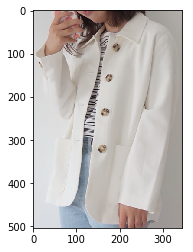

半裙_休闲裤-180911_7j5d7lh142f425f2a413gijb2d7ig_439x634.png


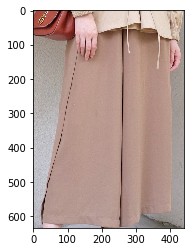

西装裤_休闲裤-181009_12gciddjgi7he472likf478j6808k_327x328.png


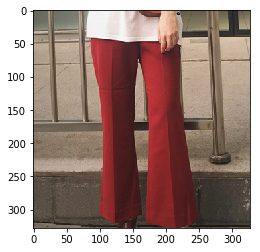

短裤_牛仔裤-180911_841g909010a5gb9cgba6h7fje03i0_316x286.png


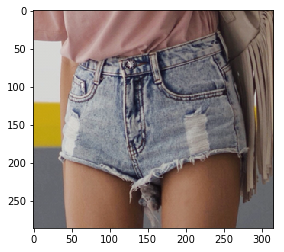

半裙_休闲裤-180928_610hfgdli31c4h5dc88ia7jjbldhi_490x491.png


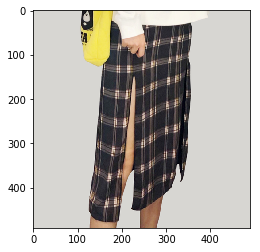

短裤_牛仔裤-180911_71ch3dl199ia4hc6fg4g3hc596gbl_290x293.png


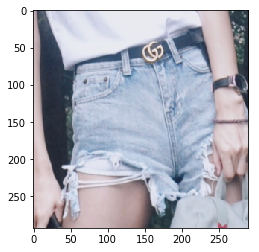

休闲裤_打底裤-181003_7fjh97la300j33ck248gf94558l17_579x580.png


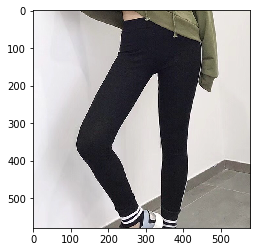

短裤_牛仔裤-180911_3gdeblfke1i7e644528e383aj4717_453x337.png


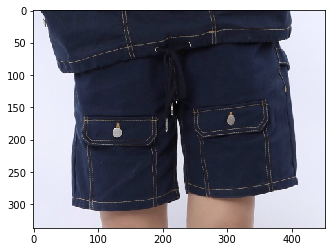

半裙_牛仔裤-180912_7hbcj23dc6c76caf59l9he748kla2_308x327.png


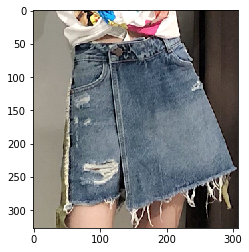

休闲裤_连衣裙-180911_5hak14b2814d393ji41d3699bh4kj_220x774.png


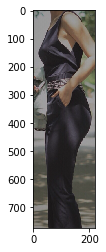

休闲裤_运动裤-180911_02k040f1jch0bdkl310il4c4h50ae_175x399.png


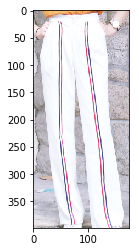

休闲裤_打底裤-180908_731ljcb3i2a52j4031d6c5igjeach_252x387.png


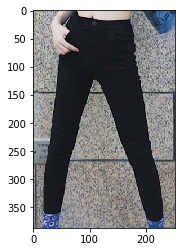

牛仔裤_连衣裙-180911_88jic5k3kdac290b260l6kci87hg0_745x727.png


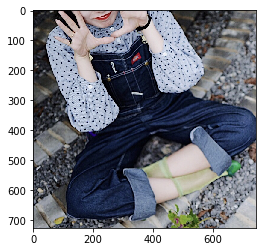

衬衫_雪纺-180911_6dlj2gij476a3lkf459igf23h10l2_861x820.jpg


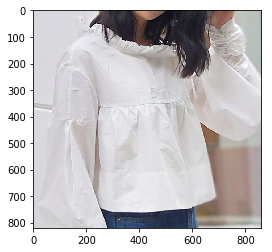

半裙_短裤-181004_46666j46l2gia63f7h6fbfhd3ac66_386x386.png


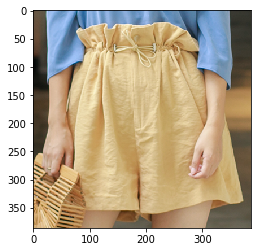

背心_衬衫-180911_26h74804jggeh701kj96c5a9eki47_441x355.png


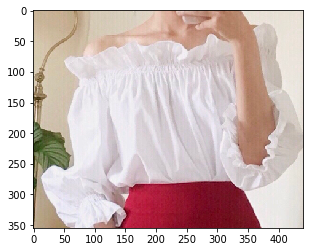

西装裤_休闲裤-180911_4kb8iii3bj5i4a9fj5a6gelb5dell_238x565.png


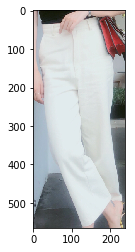

短裤_牛仔裤-180911_05jb9cee13hbce5ih4g7ik1id5baf_176x213.png


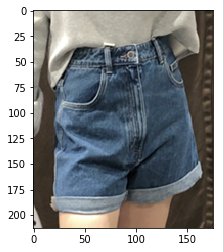

休闲裤_牛仔裤-180911_7lf30kfg4a6c03g9c79j270alk7c4_461x726.png


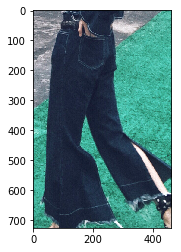

T恤_卫衣-180911_1c4khc7c3a14k886b1fh45c6iflbg_439x433.png


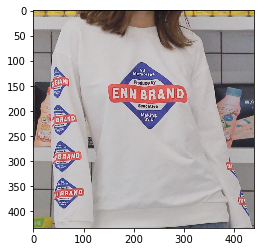

短裤_牛仔裤-180907_2l1fcde1lkkij4ic584l1delf41f6_258x254.png


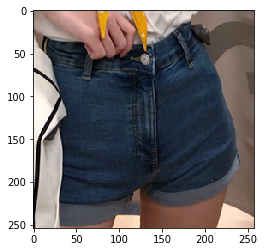

连衣裙_半裙-180911_109l6g69e2gl96b70b4e1k4hh68ja_170x375.png


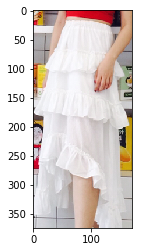

连衣裙_休闲裤-180914_3566db3fblfi9kaecajbiaggj72g9_202x561.png


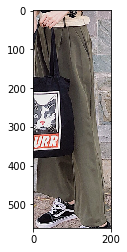

短裤_牛仔裤-180911_6a5k92hcff5a00ljc4h60dk5cl0k8_388x341.png


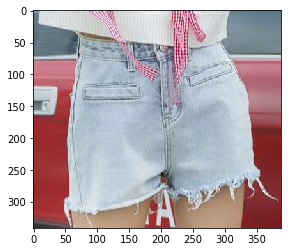

短裤_牛仔裤-180911_8bkhfc8l694e32e0ie7a2hak57d9l_272x238.png


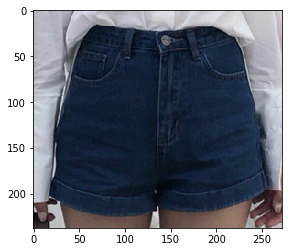

休闲裤_打底裤-180927_646371li1hc713j94ccjle1ca9122_205x206.png


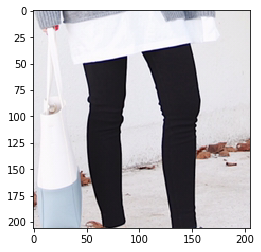

西装裤_休闲裤-181008_440b7d1fcjg6f1h35927ebg5gicb4_582x582.png


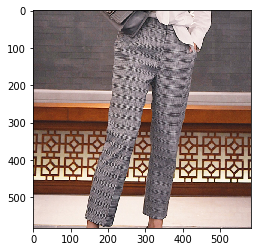

休闲裤_运动裤-181009_551j0967abh6fafik9jfae567073h_550x550.png


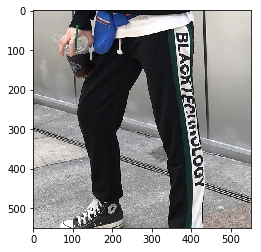

短裤_牛仔裤-180911_8e30kgh40ckhl8j6gibl1bk16bj02_358x310.png


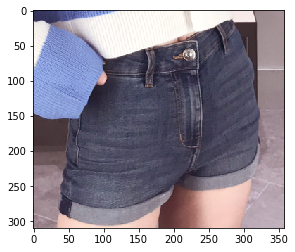

休闲裤_连衣裙-180906_22b272474adj2beaagj28bgg3je8c_284x673.png


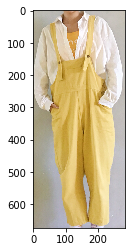

休闲裤_西装裤-180911_6848ia152agael44clg2aj6df4hhe_276x485.png


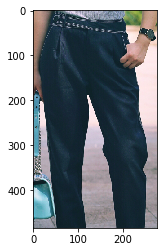

T恤_毛衣-180911_285d60gl25d7ag6jh04g3dl67hgek_306x270.png


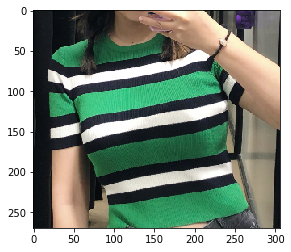

休闲裤_牛仔裤-180911_89k7j6i973ijkdcli85ekk02698j8_241x247.png


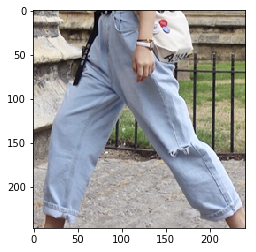

半裙_连衣裙-180925_8b419e9l55a26l0k44elj593hd21c_566x566.png


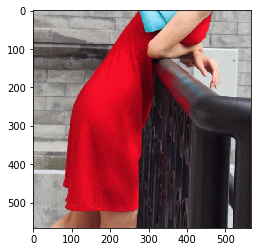

半裙_休闲裤-181003_5ehb673cd1551gh867a824k86i7d0_649x650.png


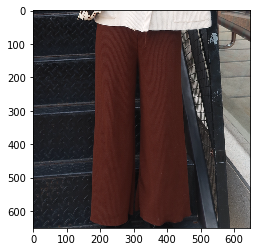

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

output_dir = '/mogu/lingfei/project/cate4/resnet50/badcase'
for file in os.listdir(output_dir):
    print(file)
    img = Image.open(output_dir + '/' + file)
    plt.figure(file.split('-')[0])
    plt.imshow(img)
    plt.show()